# Testes com busca (euclidean distances) utilizando feature extraction do imagenet

In [1]:
from collections import Counter
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time


caminho_bases = os.path.join('..', 'bases', 'vazios')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

SIZE = (224, 224)

# Recupera imagens

In [22]:
datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=1024,
    class_mode='binary',
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=512,
    class_mode='binary',
    shuffle=True
)

Found 20845 images belonging to 2 classes.
Found 2317 images belonging to 2 classes.


# Models

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, \
    BatchNormalization, concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D


SIZE = (224, 224)


nuclear_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
  Flatten(),
  Dense(128, activation='relu'),
 
])

nuclear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)       

In [24]:
batch, labels = next(validation_generator)
features_batch = nuclear_model.predict(batch)

In [25]:
ind = random.randint(0, len(features_batch))
distances = euclidean_distances([features_batch[ind]], features_batch)
sequence = np.argsort(distances)[0]
print(ind, sequence)

511 [511 108 129 456 166  99 261 468 305 498  12  87 136 412  31 504 405 365
   4 174 124 323 310 309 510  21 403 283 431  34 408 219 248  39 208  84
 387 285 368 493 421 196 495 346 425 492 267 291 249 479 484 176 125  55
 242 340 474 233 191 266 287 123 440 113  63 382 312 157 366  52 122 487
 322 329  22  41 458 442 290 270 234  60 333 496 419 436 115 320 384  98
 311 119  95 454  14 106  33 207 353 240  40 427 131   8 158 316  53 220
 152 177 445 144 473 337 391 254 430  46 457 156 358  96 480 411 447 371
 299 264  57 265  71 171 326 406 159 210 491 142 181 452 161 501 394 507
  92 163 289 120  49  44 263 367 245  78 376  27 282  47  26 213 164 258
  17 438 222  97 413 500 389 467   0 338 356 433  43 109 450 298 377 217
 204 303 280 418 162 508 416 398 143 488 218 216 330 426 472 226 362 374
 489 331 241  82 238  69 348 437 446 212 133 194 235 228 281 137 509 209
 383 175 193 229 244 179 232 317  68  59  75 343 363 214 351  42 476 350
 485 482 448 127 199  19 462 364 190  18 388  9

In [26]:
print(labels[ind], labels[sequence] )

0.0 [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

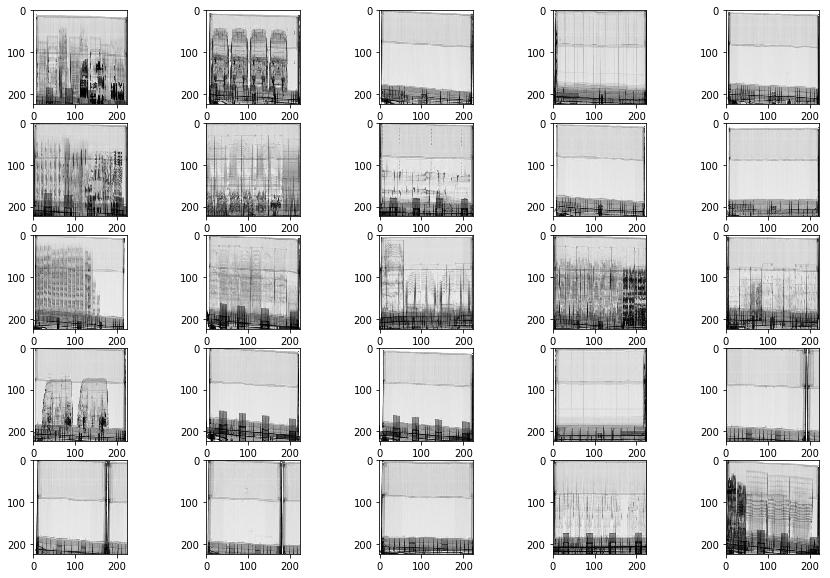

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for row in range(5):
    for col in range(5):
        img_ind = row * 5 + col
        axes[col, row].imshow(batch[sequence[img_ind]])


In [28]:
ind = random.randint(0, len(features_batch))
distances = euclidean_distances([features_batch[ind]], features_batch)
sequence = np.argsort(distances)[0]
print(ind, sequence)

77 [ 77 105 286 336 321 497  79 396 223 304  65 272 279 451   7 415 230 252
 297 211  86 420  67 197 111 306  48 150  62 300 103  45 180 135 275  13
 295 505  38 319 428 341  76 247 449 189  81 395 168  93  28 114 339 503
  23 463 318 202 183 470 243 198 439 110   2  35 301  90 185 441  91 334
 469 386 443 360  11 385 373  80 269 354 186 370 352 260 274  85 192 172
 173 188 147 404  32 268  73  36  83 293 486   1 292 121 118   5 107  37
 397 332 393 399 140  20 477 296  88 278 325 355 256 237 271 154 381 410
  89 402  56 167 307 184  16 236 246  54 455  51 432 378  58 102 251 375
 239 104 302 170 471  10 342 327 308  66 225 139 116 259 361 205 132 466
 348 294 126 392 196 502 314 345   3 221 490 483 128 248 182 468 372 303
 467 129 101 407  30 143 499 459 482 408 409 138 478 349 366 169 226 398
 481 418   0 371 193  69 452 365 109 203 228 146 485 433  26 369 460 343
 123  55 210 217 461 216 333 326 358 227 320 419 510 400  96 338 453 430
 317 363  52 388 233 214  64 218 472 479 457 231

In [29]:
print(labels[ind], labels[sequence])

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1

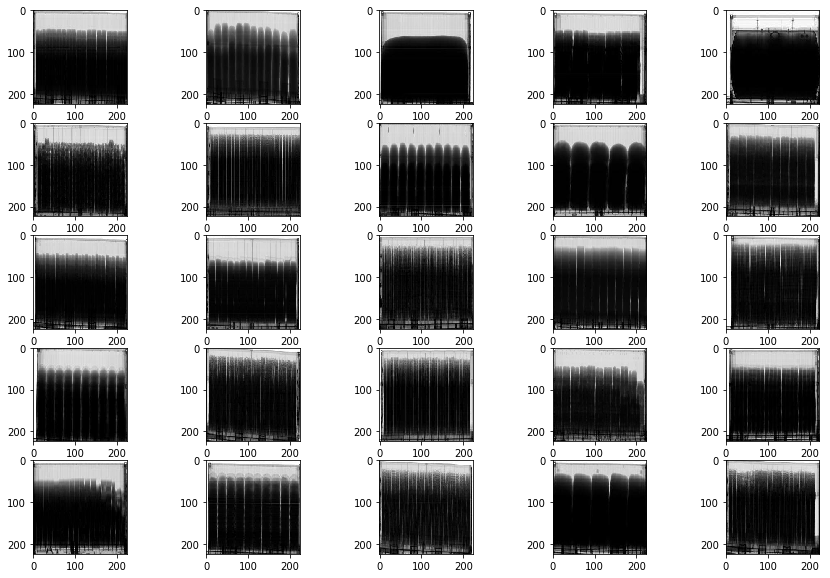

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for row in range(5):
    for col in range(5):
        img_ind = row * 5 + col
        axes[col, row].imshow(batch[sequence[img_ind]])


In [31]:
def get_batch(generator, model=nuclear_model):
    batch, labels = next(validation_generator)
    features_batch = model.predict(batch)
    return features_batch, labels
    
def get_sequence(features, ind):
    distances = euclidean_distances([features[ind]], features)
    sequence = np.argsort(distances)[0]
    return sequence


In [32]:
ROUNDS = 200
# Coincidências de classe em 10 itens
train_generator.reset()
for r in range(1, 6):
    X, y = get_batch(train_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:10])
        # print(s, acertos)
        acerto_batch += acertos
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 10)))


Acertos no batch 1: 0.90
Acertos no batch 2: 0.85
Acertos no batch 3: 0.90
Acertos no batch 4: 0.88
Acertos no batch 5: 0.90


In [33]:
validation_generator.reset()
for r in range(1, 6):
    X, y = get_batch(validation_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:10])
        # print(s, acertos)
        acerto_batch += acertos
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 10) ))


Acertos no batch 1: 0.90
Acertos no batch 2: 0.89
Acertos no batch 3: 0.90
Acertos no batch 4: 0.89
Acertos no batch 5: 0.90


In [34]:
# Coincidências de classe em 20 itens
train_generator.reset()
for r in range(1, 11):
    X, y = get_batch(train_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:20])
        # print(s, acertos)
        acerto_batch += acertos
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 20)))


Acertos no batch 1: 0.88
Acertos no batch 2: 0.84
Acertos no batch 3: 0.91
Acertos no batch 4: 0.87
Acertos no batch 5: 0.86
Acertos no batch 6: 0.89
Acertos no batch 7: 0.87
Acertos no batch 8: 0.91
Acertos no batch 9: 0.88
Acertos no batch 10: 0.85


In [35]:
# Coincidências de classe em 20 itens - por classe
train_generator.reset()
acerto_total = Counter()
total = Counter()
for r in range(1, 11):
    X, y = get_batch(train_generator)
    acerto_batch = 0
    for s in range(ROUNDS):
        ind = random.randint(0, len(y) - 1)
        seq = get_sequence(X, ind)
        acertos = sum(y[ind] ==  y[seq][:20])
        total[y[ind]] += 20
        acerto_total[y[ind]] += acertos
        # print(s, acertos)
        acerto_batch += acertos
    print('Acertos no batch {:d}: {:0.2f}'.format(r, acerto_batch / (ROUNDS * 20)))


Acertos no batch 1: 0.88
Acertos no batch 2: 0.92
Acertos no batch 3: 0.90
Acertos no batch 4: 0.87
Acertos no batch 5: 0.86
Acertos no batch 6: 0.89
Acertos no batch 7: 0.89
Acertos no batch 8: 0.89
Acertos no batch 9: 0.88
Acertos no batch 10: 0.87


In [36]:
print('0 = não vazio\n1 = vazio')
for classe in [0, 1]:
    print('Acerto classe {}: {:d} de {:d} ({:0.2f})'.format(
           classe, acerto_total[classe], total[classe],
           (acerto_total[classe] / total[classe]) )
         )


0 = não vazio
1 = vazio
Acerto classe 0: 16939 de 20020 (0.85)
Acerto classe 1: 18459 de 19980 (0.92)
